# 📊 Recolección y Procesamiento de Datos de Mercado

Este notebook implementa la recolección y procesamiento inicial de datos para el análisis del mercado mexicano.

## Contenido
1. Setup y Configuración
2. Recolección de Datos
   - Datos de Banxico
   - Datos de Yahoo Finance
   - Noticias del Mercado
3. Procesamiento y Validación
4. Análisis Exploratorio Inicial
5. Almacenamiento de Datos

## Dependencias
- pandas
- numpy
- matplotlib
- seaborn
- plotly

In [1]:
# Importación de librerías
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Configuración de visualización
sns.set_theme(style="whitegrid")  # Esto reemplaza plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', None)

# Verificar estructura del proyecto
notebook_dir = os.getcwd()
print("Directorio actual:", notebook_dir)

# Subir un nivel si estamos en notebooks/
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
else:
    project_dir = notebook_dir
    
print("Directorio del proyecto:", project_dir)

# Verificar existencia de directorios
src_path = os.path.join(project_dir, 'src')
data_path = os.path.join(src_path, 'data')

print("\nVerificando estructura del proyecto:")
print(f"¿Existe src/?: {os.path.exists(src_path)}")
print(f"¿Existe src/data/?: {os.path.exists(data_path)}")

if os.path.exists(data_path):
    print("\nContenido de src/data/:")
    print(os.listdir(data_path))

# Agregar al path solo si existe
if os.path.exists(project_dir):
    sys.path.insert(0, project_dir)
    print("\nPath actualizado:", project_dir)

# Intentar importar solo si existe el path
try:
    from src.data.collectors import MarketDataCollector
    from src.data.processors import EnhancedMarketProcessor
    print("\nMódulos importados correctamente")
except ImportError as e:
    print("\nError importando módulos:", str(e))

Directorio actual: /Users/mayel/repos/banco-base-proyecto-test/notebooks
Directorio del proyecto: /Users/mayel/repos/banco-base-proyecto-test

Verificando estructura del proyecto:
¿Existe src/?: True
¿Existe src/data/?: True

Contenido de src/data/:
['collectors.py', '__init__.py', '__pycache__', 'processors.py']

Path actualizado: /Users/mayel/repos/banco-base-proyecto-test

Módulos importados correctamente


## 1. Inicialización de Colectores y Procesadores

In [2]:
# Inicializar colector y procesador
collector = MarketDataCollector()
processor = EnhancedMarketProcessor()

# Definir período de análisis
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # 1 año de datos

# Convertir fechas a formato string
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Período de análisis: {start_date_str} a {end_date_str}")

Período de análisis: 2023-11-11 a 2024-11-10


## 2. Recolección de Datos
### 2.1 Datos de Tipo de Cambio (Banxico)

In [4]:
# Obtener datos de tipo de cambio USD/MXN desde Banxico
fx_data = collector.get_banxico_data(start_date_str, end_date_str)

# Verificar si se obtuvieron datos
if fx_data.empty:
    print("No se obtuvieron datos de tipo de cambio USD/MXN.")
else:
    # Visualizar el tipo de cambio USD/MXN
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['usdmxn_fix'],
        mode='lines',
        name='USD/MXN Fix'
    ))

    fig.update_layout(
        title='Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Tipo de Cambio',
        template='plotly_white'
    )
    fig.show()

    # Estadísticas básicas del tipo de cambio
    print("\nEstadísticas del Tipo de Cambio USD/MXN:")
    print(fx_data['usdmxn_fix'].describe())
    
    # Calcular los rendimientos logarítmicos del tipo de cambio
    fx_data['returns'] = np.log(fx_data['usdmxn_fix'] / fx_data['usdmxn_fix'].shift(1))

    # Visualizar rendimientos del tipo de cambio USD/MXN
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=fx_data.index,
        y=fx_data['returns'],
        mode='lines',
        name='Rendimientos USD/MXN'
    ))

    fig.update_layout(
        title='Rendimientos Logarítmicos del Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Rendimiento',
        template='plotly_white'
    )
    fig.show()

    # Estadísticas básicas de los rendimientos
    print("\nEstadísticas de los Rendimientos del Tipo de Cambio USD/MXN:")
    print(fx_data['returns'].describe())



Estadísticas del Tipo de Cambio USD/MXN:
count    249.000000
mean      17.908787
std        1.155108
min       16.335700
25%       17.004200
50%       17.299000
75%       19.032000
max       20.309300
Name: usdmxn_fix, dtype: float64



Estadísticas de los Rendimientos del Tipo de Cambio USD/MXN:
count    248.000000
mean       0.000539
std        0.007955
min       -0.023999
25%       -0.004088
50%        0.000064
75%        0.004514
max        0.040720
Name: returns, dtype: float64


### 2.2 Datos de Acciones (Yahoo Finance)

In [20]:
# Lista de tickers mexicanos relevantes, incluyendo el tipo de cambio USD/MXN
mx_tickers = ['GFNORTEO.MX', 'VOLARA.MX', 'MXNUSD=X']

# Obtener datos de acciones y tipo de cambio
stocks_data = collector.get_yahoo_data(mx_tickers, start_date_str, end_date_str)

# Verificar si se obtuvieron datos
if stocks_data.empty:
    print("No se obtuvieron datos para los tickers proporcionados.")
else:
    # Filtrar tickers con datos completos
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    complete_data_tickers = [
        ticker for ticker in mx_tickers if all((ticker, col) in stocks_data.columns for col in required_columns)
    ]
    
    # Visualización de retornos normalizados
    fig = go.Figure()
    for ticker in complete_data_tickers:
        normalized_price = stocks_data[(ticker, 'Close')] / stocks_data[(ticker, 'Close')].iloc[0]
        fig.add_trace(go.Scatter(
            x=stocks_data.index,
            y=normalized_price,
            mode='lines',
            name=ticker
        ))

    fig.update_layout(
        title='Retornos Normalizados de Acciones Mexicanas y Tipo de Cambio USD/MXN',
        xaxis_title='Fecha',
        yaxis_title='Retorno Normalizado',
        template='plotly_white'
    )
    fig.show()
    
    # Visualización específica del tipo de cambio USD/MXN
    if 'MXNUSD=X' in complete_data_tickers:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=stocks_data.index,
            y=stocks_data[('MXNUSD=X', 'Close')],
            mode='lines',
            name='USD/MXN'
        ))

        fig.update_layout(
            title='Tipo de Cambio USD/MXN',
            xaxis_title='Fecha',
            yaxis_title='USD/MXN',
            template='plotly_white'
        )
        fig.show()

    # Estadísticas básicas de los precios de cierre
    print("\nEstadísticas de Precios de Cierre:")
    for ticker in complete_data_tickers:
        print(f"\nTicker: {ticker}")
        print(stocks_data[(ticker, 'Close')].describe())



Estadísticas de Precios de Cierre:

Ticker: GFNORTEO.MX
count     24.000000
mean     144.848334
std        3.963909
min      137.979996
25%      141.879997
50%      144.385002
75%      148.354996
max      151.080002
Name: (GFNORTEO.MX, Close), dtype: float64

Ticker: VOLARA.MX
count    24.000000
mean     13.960000
std       1.081388
min      12.000000
25%      13.517500
50%      14.170000
75%      14.912500
max      15.230000
Name: (VOLARA.MX, Close), dtype: float64

Ticker: MXNUSD=X
count    22.000000
mean      0.050277
std       0.000628
min       0.049586
25%       0.049814
50%       0.050147
75%       0.050467
max       0.051815
Name: (MXNUSD=X, Close), dtype: float64


### 2.3 Noticias del Mercado

Últimas 5 noticias y su sentimiento:


,title,sentiment_score
date,,
2024-11-08 23:02:11,Peso resiente nombramiento de representante co...,0.0
2024-11-08 21:56:29,"S&P 500 supera los 6,000 puntos, impulsado por...",0.0
2024-11-08 17:34:47,Tesla alcanza valor de mercado de 1 billón de ...,0.0
2024-11-08 14:52:30,Nerviosismo por acciones de Trump hace retroce...,0.0
2024-11-07 22:15:34,Tipo de cambio baja de los 20 pesos por dólar,-0.5


/Users/mayel/repos/banco-base-proyecto-test/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



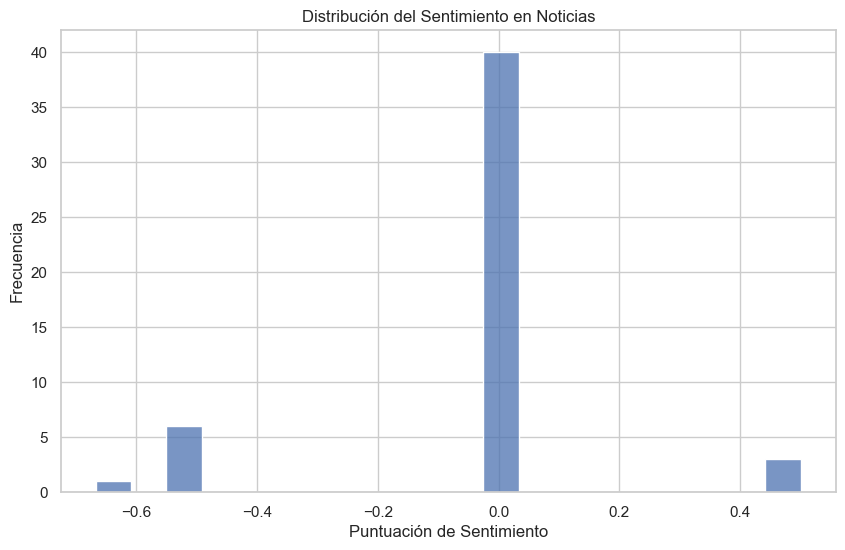

In [5]:
# Obtener noticias
news_data = collector.get_rss_news()

# Mostrar últimas noticias y su sentimiento
print("Últimas 5 noticias y su sentimiento:")
latest_news = news_data[['title', 'sentiment_score']].head()
display(latest_news)

# Visualizar distribución de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(data=news_data, x='sentiment_score', bins=20)
plt.title('Distribución del Sentimiento en Noticias')
plt.xlabel('Puntuación de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

## 3. Análisis Estadístico de los Datos

✓ Datos completos obtenidos para GFNORTEO.MX
✓ Datos completos obtenidos para VOLARA.MX
✓ Datos completos obtenidos para MXNUSD=X


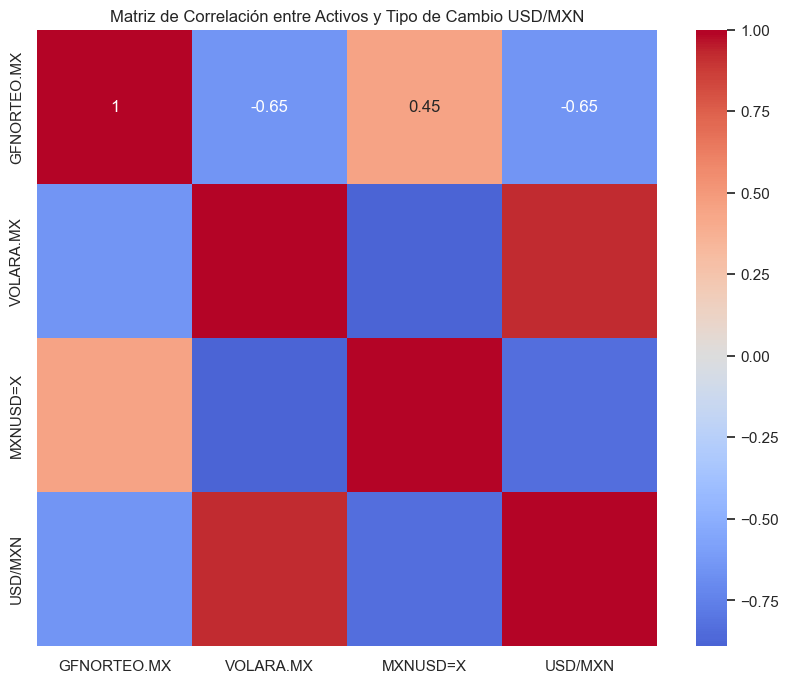


Estadísticas de Rendimientos del Tipo de Cambio USD/MXN:
count    248.000000
mean       0.000539
std        0.007955
min       -0.023999
25%       -0.004088
50%        0.000064
75%        0.004514
max        0.040720
Name: returns_usd_mxn, dtype: float64

Estadísticas de Precios de Cierre:

Ticker: GFNORTEO.MX
count     24.000000
mean     144.848334
std        3.963909
min      137.979996
25%      141.879997
50%      144.385002
75%      148.354996
max      151.080002
Name: GFNORTEO.MX, dtype: float64

Ticker: VOLARA.MX
count    24.000000
mean     13.960000
std       1.081388
min      12.000000
25%      13.517500
50%      14.170000
75%      14.912500
max      15.230000
Name: VOLARA.MX, dtype: float64

Ticker: MXNUSD=X
count    22.000000
mean      0.050277
std       0.000628
min       0.049586
25%       0.049814
50%       0.050147
75%       0.050467
max       0.051815
Name: MXNUSD=X, dtype: float64

Ticker: USD/MXN
count    24.000000
mean     19.866475
std       0.283713
min      19.342

In [10]:
# Lista de tickers relevantes (acciones y tipo de cambio USD/MXN)
mx_tickers = ['GFNORTEO.MX', 'VOLARA.MX', 'MXNUSD=X']

# Obtener datos de tipo de cambio USD/MXN desde Banxico
fx_data = collector.get_banxico_data(start_date_str, end_date_str)
if fx_data.empty:
    print("No se obtuvieron datos de tipo de cambio USD/MXN.")
else:
    # Calcular rendimientos logarítmicos de USD/MXN para medir volatilidad
    fx_data['returns_usd_mxn'] = np.log(fx_data['usdmxn_fix'] / fx_data['usdmxn_fix'].shift(1))

    # Obtener datos de acciones y tipo de cambio desde Yahoo Finance
    stocks_data = collector.get_yahoo_data(mx_tickers, start_date_str, end_date_str)
    if stocks_data.empty:
        print("No se obtuvieron datos para los tickers proporcionados.")
    else:
        # Extraer precios de cierre y agregar tipo de cambio USD/MXN
        close_prices = pd.DataFrame({ticker: stocks_data[(ticker, 'Close')] for ticker in mx_tickers if (ticker, 'Close') in stocks_data.columns})
        close_prices['USD/MXN'] = fx_data['usdmxn_fix']

        # Visualización de Retornos Normalizados
        fig = go.Figure()
        for ticker in close_prices.columns:
            normalized_price = close_prices[ticker] / close_prices[ticker].iloc[0]
            fig.add_trace(go.Scatter(x=close_prices.index, y=normalized_price, mode='lines', name=ticker))
        fig.update_layout(title='Retornos Normalizados de Activos y Tipo de Cambio USD/MXN', xaxis_title='Fecha', yaxis_title='Retorno Normalizado', template='plotly_white')
        fig.show()

        # Calcular y visualizar matriz de correlación
        corr_matrix = close_prices.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Matriz de Correlación entre Activos y Tipo de Cambio USD/MXN')
        plt.show()

        # Análisis de Rendimientos y Volatilidad del Tipo de Cambio USD/MXN
        print("\nEstadísticas de Rendimientos del Tipo de Cambio USD/MXN:")
        print(fx_data['returns_usd_mxn'].describe())

        # Análisis de estadísticas de los precios de cierre de los activos
        print("\nEstadísticas de Precios de Cierre:")
        for ticker in close_prices.columns:
            print(f"\nTicker: {ticker}")
            print(close_prices[ticker].describe())


## 4. Almacenamiento de Datos

In [12]:
import os

# Crear directorio si no existe
output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

# Crear diccionario con todos los datos relevantes
market_data = {
    'fx_rates': fx_data,                      # Tipo de cambio USD/MXN y rendimientos
    'stocks': stocks_data,                    # Datos de las acciones obtenidos de Yahoo Finance
    'news': news_data,                        # Noticias de fuentes relevantes
    'correlation_matrix': corr_matrix,        # Matriz de correlación entre activos
}

# Guardar los datos procesados en formato CSV
for name, data in market_data.items():
    if isinstance(data, pd.DataFrame):  # Asegurarse de que es un DataFrame antes de guardar
        data.to_csv(f'{output_dir}/{name}_{end_date_str}.csv', index=True)
    else:
        print(f"{name} no es un DataFrame y no se guardará como CSV.")

print(f"Datos guardados exitosamente en el directorio '{output_dir}'")



Datos guardados exitosamente en el directorio 'data/processed'


## 5. Resumen y Conclusiones

Este notebook ha realizado:
1. Recolección exitosa de datos de múltiples fuentes
2. Procesamiento y validación de datos
3. Análisis exploratorio inicial
4. Visualizaciones importantes del mercado
5. Almacenamiento de datos procesados

### Próximos Pasos
- Realizar análisis exploratorio más detallado
- Implementar feature engineering
- Desarrollar modelos predictivos
- Crear estrategias de trading